# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# # PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# # FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('se_resnext50_2lr_5e-4_imagenetch3-simpleaug')

TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 35.2 s, sys: 32.2 s, total: 1min 7s
Wall time: 6.99 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('TH', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

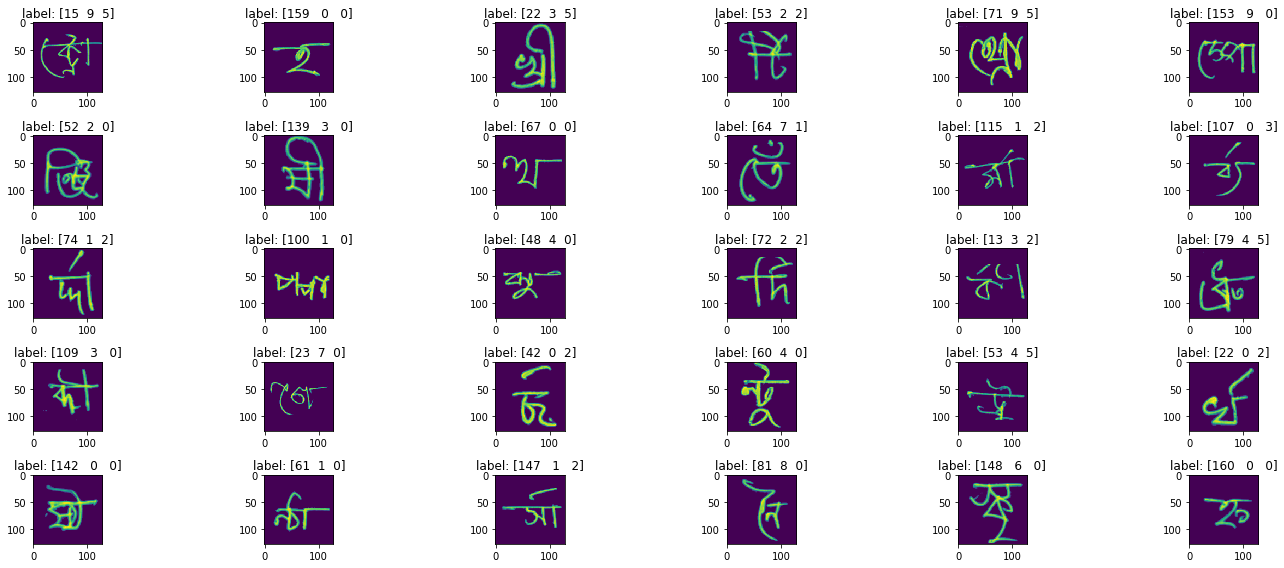

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

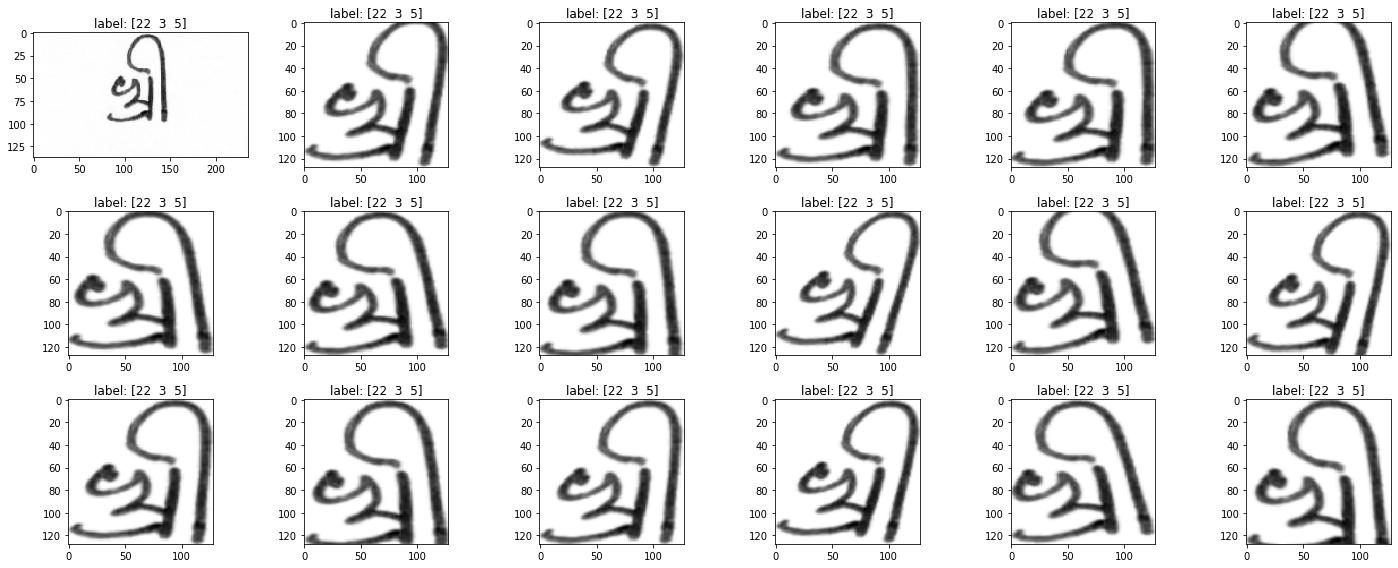

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

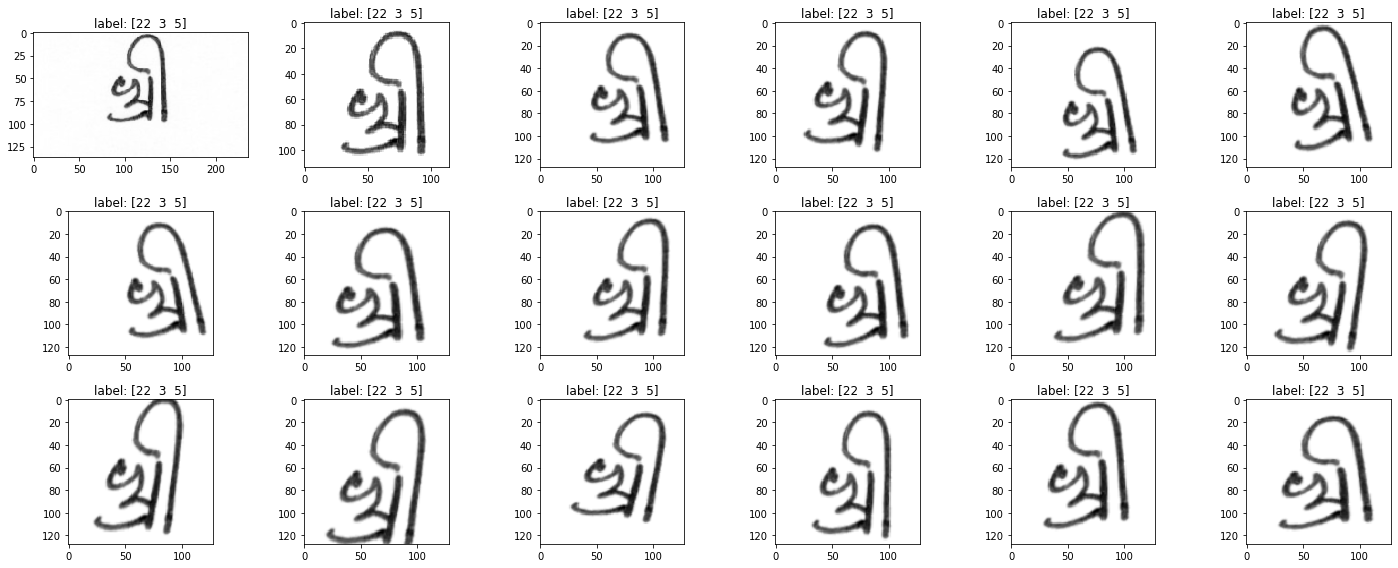

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

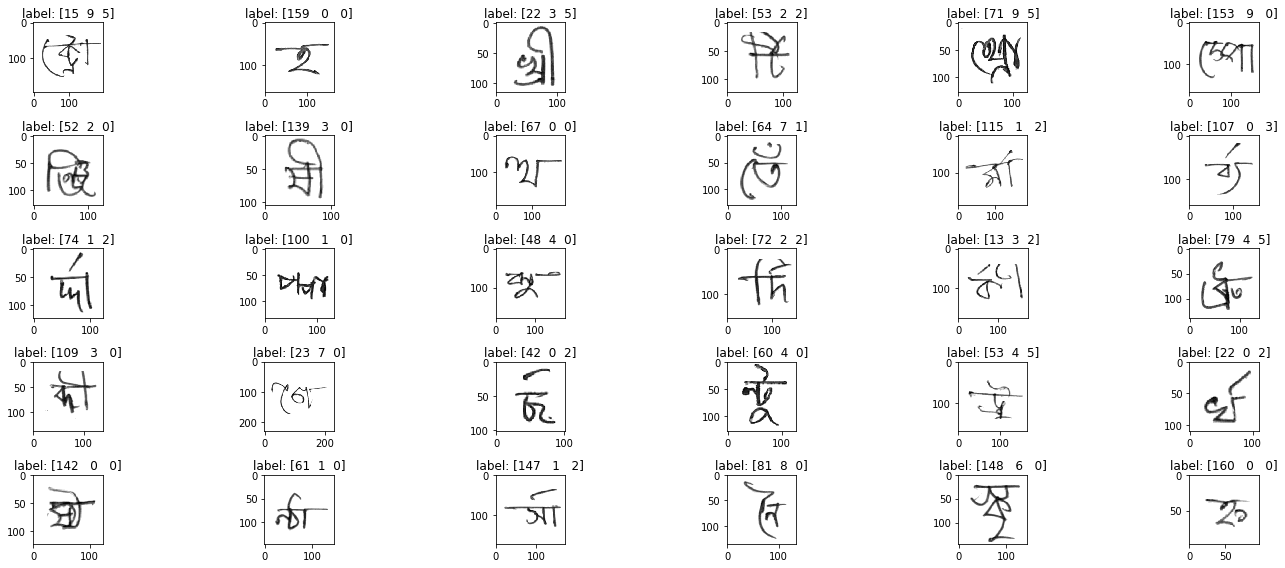

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

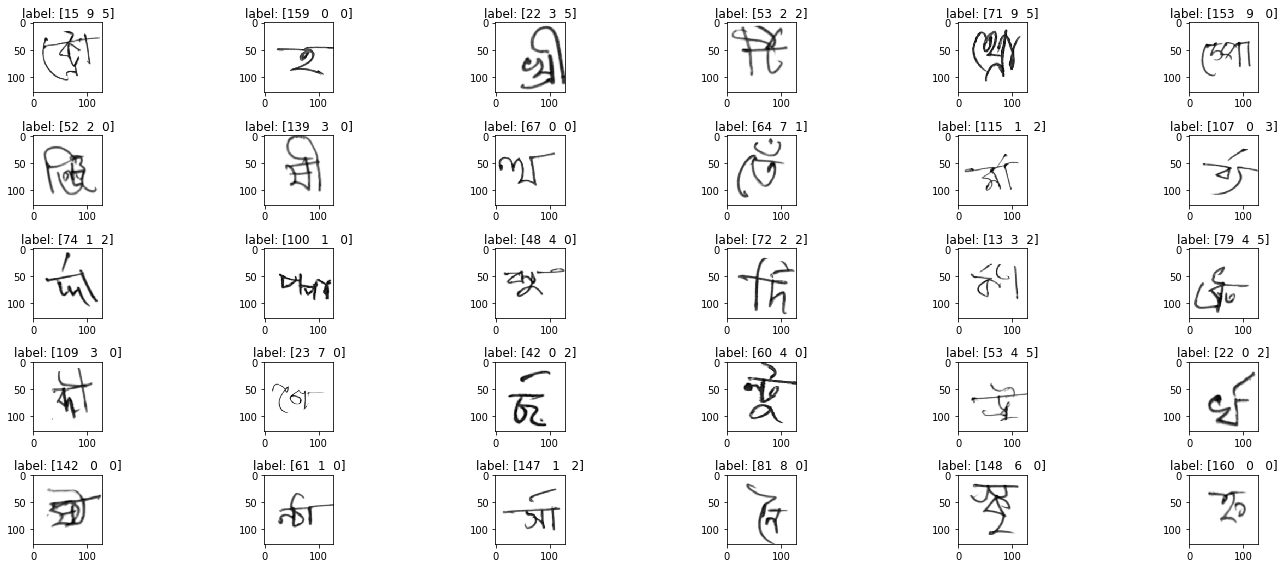

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:
# train_transform = Transform(
#     size=(image_size, image_size), 
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
#     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
#     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_transform = Transform(
    size=(image_size, image_size), cutout_ratio=0.5) #threshold=20.,
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

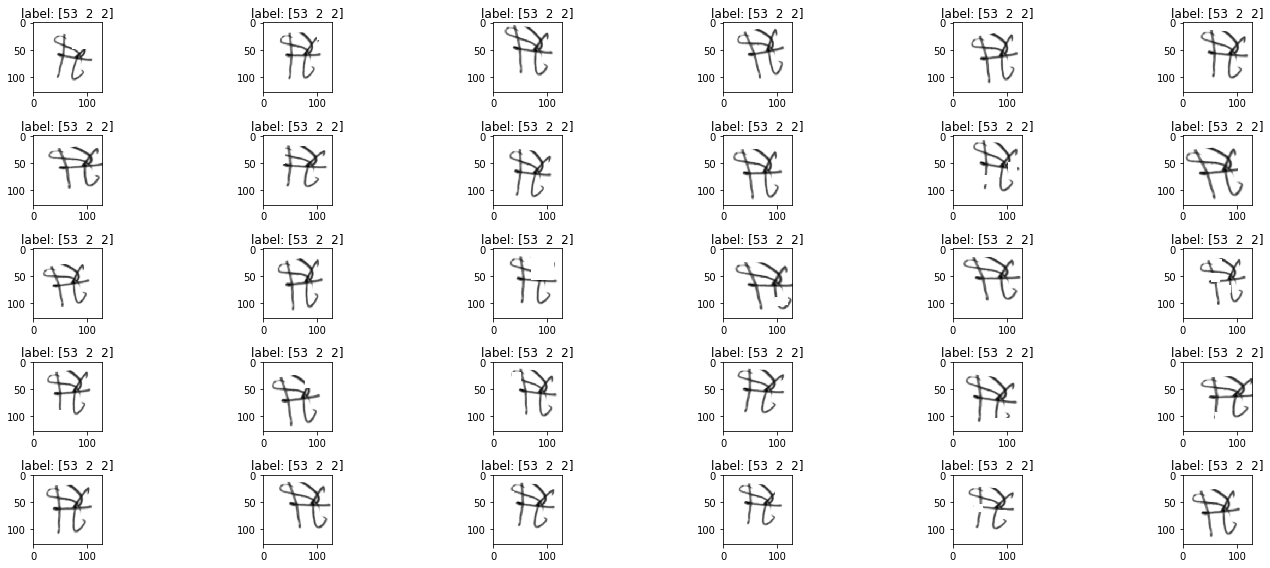

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[3]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

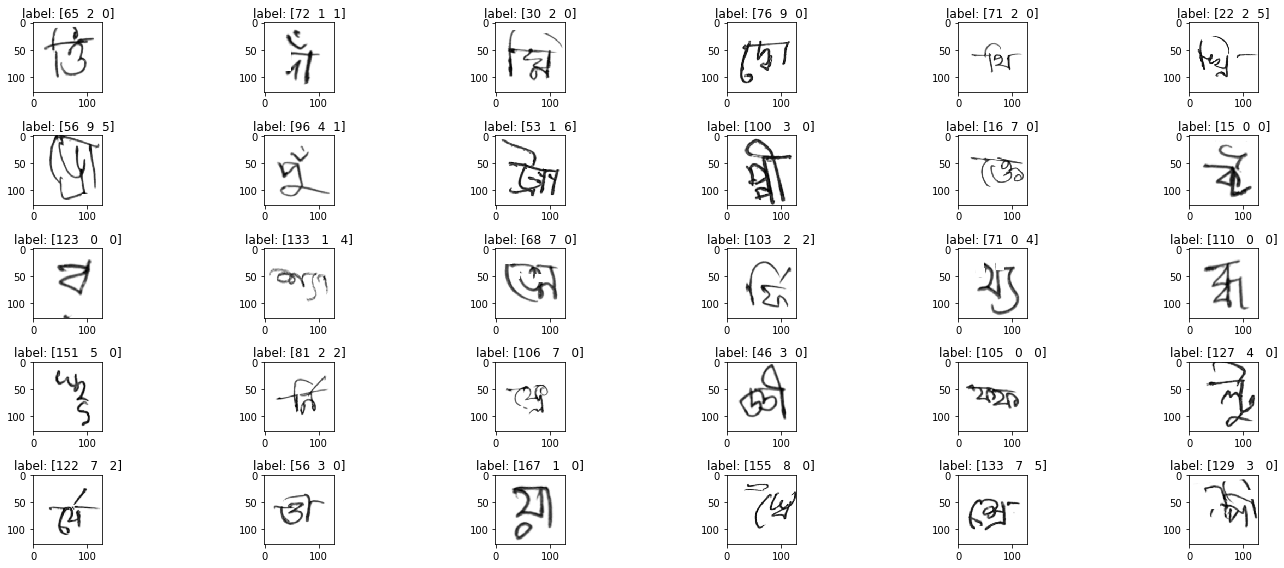

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

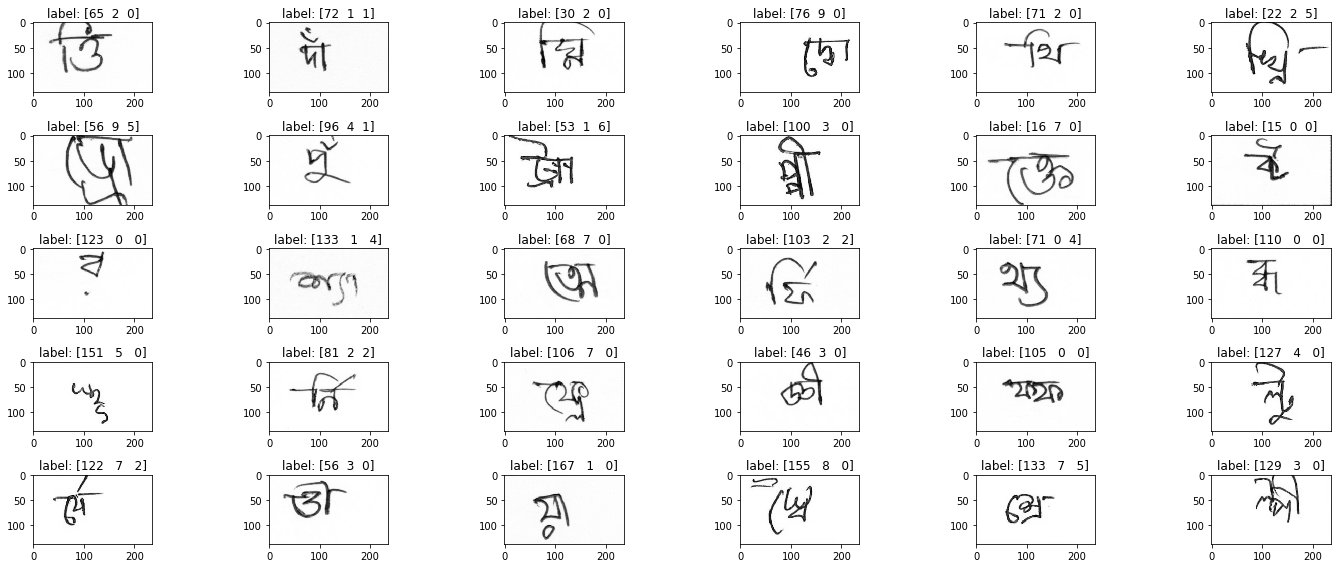

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [28]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
a = np.array([2,3])
b = np.array([4,5,6])

In [31]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [32]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [33]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, out = 1000, dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        return x

In [34]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [35]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [36]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [37]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         print(self.base_model)
        names = []
        for name, child in self.base_model.named_children():
            names.append(name)
            
        arch = self.base_model
        arch = list(arch.children())
        #saving the weights of the forst conv in w
        w = arch[0][0].weight
        #creating new Conv2d to accept 1 channel 
        arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #substituting weights of newly created Conv2d with w from but we have to take mean
        #to go from  3 channel to 1
        arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
        arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
#         print(arch)
        self.base_model = arch
#         print("#######################################")
#         print(self.base_model)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        
        hdim = 512
        self.classifer = ClassifierNew(inp = inch, h1=hdim, out = out_dim, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.base_model.layer0(x)
        h = self.base_model.layer1(h)
        h = self.base_model.layer2(h)
        h = self.base_model.layer3(h)
        h = self.base_model.layer4(h)
        
        h = self.classifer(h)

        return h

In [38]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [39]:
# print_grad_status(predictortmp)

In [40]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [41]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [42]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [43]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [44]:
predictortmp = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
for name, child in predictortmp.named_children():
    print(name)
print_base_layers(predictortmp)

base_model
classifer
base model layer names::
layer0
layer1
layer2
layer3
layer4
avg_pool
last_linear


In [45]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [46]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.base_model.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-6)
    lr_10 = max(learning_rate/10, 5e-6)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
        dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
        dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [47]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 2*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [48]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [49]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [50]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [51]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [52]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [53]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [54]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [55]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [56]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [57]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [58]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [59]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
#     optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=3e-4)
    optimizer = get_optimizer_adam(classifier, learning_rate=5e-4, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  2.795979 train/loss_grapheme  2.197777 train/loss_vowel  0.320946 train/loss_consonant  0.277256 train/acc_grapheme  0.728702 train/acc_vowel  0.904980 train/acc_consonant  0.917559 train/recall  0.748324 val/loss  0.835448 val/loss_grapheme  0.637948 val/loss_vowel  0.100442 val/loss_consonant  0.097059 val/acc_grapheme  0.907190 val/acc_vowel  0.971644 val/acc_consonant  0.971171 val/recall  0.903947 lr  0.000500 elapsed_time  605.200114 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  1.043556 train/loss_grapheme  0.799881 train/loss_vowel  0.124821 train/loss_consonant  0.118853 train/acc_grapheme  0.884211 train/acc_vowel  0.963366 train/acc_consonant  0.963640 train/recall  0.883968 val/loss  0.666576 val/loss_grapheme  0.512578 val/loss_vowel  0.078544 val/loss_consonant  0.075453 val/acc_grapheme  0.925139 val/acc_vowel  0.978067 val/acc_consonant  0.977096 val/recall  0.920062 lr  0.000500 elapsed_time  1203.829162 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.838130 train/loss_grapheme  0.638759 train/loss_vowel  0.102764 train/loss_consonant  0.096607 train/acc_grapheme  0.905634 train/acc_vowel  0.969827 train/acc_consonant  0.970561 train/recall  0.902918 val/loss  0.575874 val/loss_grapheme  0.440009 val/loss_vowel  0.066466 val/loss_consonant  0.069399 val/acc_grapheme  0.935123 val/acc_vowel  0.981428 val/acc_consonant  0.979561 val/recall  0.933132 lr  0.000500 elapsed_time  1800.891730 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.727433 train/loss_grapheme  0.551068 train/loss_vowel  0.090221 train/loss_consonant  0.086144 train/acc_grapheme  0.917988 train/acc_vowel  0.973934 train/acc_consonant  0.974034 train/recall  0.915211 val/loss  0.533282 val/loss_grapheme  0.403123 val/loss_vowel  0.062650 val/loss_consonant  0.067509 val/acc_grapheme  0.942741 val/acc_vowel  0.983196 val/acc_consonant  0.980631 val/recall  0.939057 lr  0.000500 elapsed_time  2398.575006 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.660614 train/loss_grapheme  0.496938 train/loss_vowel  0.083963 train/loss_consonant  0.079714 train/acc_grapheme  0.926695 train/acc_vowel  0.976100 train/acc_consonant  0.975864 train/recall  0.923381 val/loss  0.518366 val/loss_grapheme  0.393038 val/loss_vowel  0.062550 val/loss_consonant  0.062778 val/acc_grapheme  0.943238 val/acc_vowel  0.983445 val/acc_consonant  0.981727 val/recall  0.939291 lr  0.000500 elapsed_time  2995.561389 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.601542 train/loss_grapheme  0.450563 train/loss_vowel  0.076723 train/loss_consonant  0.074256 train/acc_grapheme  0.932701 train/acc_vowel  0.977905 train/acc_consonant  0.977787 train/recall  0.928674 val/loss  0.498984 val/loss_grapheme  0.374684 val/loss_vowel  0.061063 val/loss_consonant  0.063237 val/acc_grapheme  0.946226 val/acc_vowel  0.984241 val/acc_consonant  0.981627 val/recall  0.942278 lr  0.000500 elapsed_time  3591.682640 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.559987 train/loss_grapheme  0.418046 train/loss_vowel  0.072310 train/loss_consonant  0.069632 train/acc_grapheme  0.936230 train/acc_vowel  0.979212 train/acc_consonant  0.978976 train/recall  0.932473 val/loss  0.485311 val/loss_grapheme  0.365852 val/loss_vowel  0.060786 val/loss_consonant  0.058673 val/acc_grapheme  0.948367 val/acc_vowel  0.984864 val/acc_consonant  0.983320 val/recall  0.944759 lr  0.000500 elapsed_time  4188.465879 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.524551 train/loss_grapheme  0.390101 train/loss_vowel  0.069266 train/loss_consonant  0.065184 train/acc_grapheme  0.941944 train/acc_vowel  0.979891 train/acc_consonant  0.980538 train/recall  0.937994 val/loss  0.470795 val/loss_grapheme  0.352008 val/loss_vowel  0.057931 val/loss_consonant  0.060856 val/acc_grapheme  0.949313 val/acc_vowel  0.985013 val/acc_consonant  0.982374 val/recall  0.945654 lr  0.000500 elapsed_time  4785.552846 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.496090 train/loss_grapheme  0.368613 train/loss_vowel  0.064572 train/loss_consonant  0.062905 train/acc_grapheme  0.943668 train/acc_vowel  0.981179 train/acc_consonant  0.981030 train/recall  0.940023 val/loss  0.471530 val/loss_grapheme  0.352294 val/loss_vowel  0.059150 val/loss_consonant  0.060086 val/acc_grapheme  0.949587 val/acc_vowel  0.985013 val/acc_consonant  0.982972 val/recall  0.945985 lr  0.000500 elapsed_time  5383.402506 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.468107 train/loss_grapheme  0.345890 train/loss_vowel  0.062123 train/loss_consonant  0.060093 train/acc_grapheme  0.947576 train/acc_vowel  0.982424 train/acc_consonant  0.981640 train/recall  0.943522 val/loss  0.460941 val/loss_grapheme  0.342905 val/loss_vowel  0.061749 val/loss_consonant  0.056287 val/acc_grapheme  0.952500 val/acc_vowel  0.984515 val/acc_consonant  0.984291 val/recall  0.948682 lr  0.000500 elapsed_time  5980.536602 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.446819 train/loss_grapheme  0.332682 train/loss_vowel  0.057906 train/loss_consonant  0.056231 train/acc_grapheme  0.949612 train/acc_vowel  0.983376 train/acc_consonant  0.982897 train/recall  0.945877 val/loss  0.454770 val/loss_grapheme  0.343771 val/loss_vowel  0.054237 val/loss_consonant  0.056762 val/acc_grapheme  0.951927 val/acc_vowel  0.986208 val/acc_consonant  0.983793 val/recall  0.948987 lr  0.000500 elapsed_time  6576.582612 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.429892 train/loss_grapheme  0.317685 train/loss_vowel  0.056865 train/loss_consonant  0.055342 train/acc_grapheme  0.951417 train/acc_vowel  0.983700 train/acc_consonant  0.983476 train/recall  0.948045 val/loss  0.444443 val/loss_grapheme  0.334126 val/loss_vowel  0.053782 val/loss_consonant  0.056536 val/acc_grapheme  0.952724 val/acc_vowel  0.986930 val/acc_consonant  0.984540 val/recall  0.949310 lr  0.000500 elapsed_time  7174.826985 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.405490 train/loss_grapheme  0.298422 train/loss_vowel  0.054552 train/loss_consonant  0.052516 train/acc_grapheme  0.954441 train/acc_vowel  0.984142 train/acc_consonant  0.984565 train/recall  0.950887 val/loss  0.445134 val/loss_grapheme  0.333662 val/loss_vowel  0.056453 val/loss_consonant  0.055019 val/acc_grapheme  0.953695 val/acc_vowel  0.986034 val/acc_consonant  0.984266 val/recall  0.948617 lr  0.000500 elapsed_time  7771.378639 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.391731 train/loss_grapheme  0.287211 train/loss_vowel  0.053211 train/loss_consonant  0.051310 train/acc_grapheme  0.956060 train/acc_vowel  0.984745 train/acc_consonant  0.984646 train/recall  0.951934 val/loss  0.450717 val/loss_grapheme  0.339000 val/loss_vowel  0.057004 val/loss_consonant  0.054713 val/acc_grapheme  0.953570 val/acc_vowel  0.985785 val/acc_consonant  0.984664 val/recall  0.948914 lr  0.000500 elapsed_time  8367.752519 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.382429 train/loss_grapheme  0.280883 train/loss_vowel  0.051107 train/loss_consonant  0.050439 train/acc_grapheme  0.957504 train/acc_vowel  0.985386 train/acc_consonant  0.984770 train/recall  0.953768 val/loss  0.439559 val/loss_grapheme  0.332136 val/loss_vowel  0.053740 val/loss_consonant  0.053683 val/acc_grapheme  0.953794 val/acc_vowel  0.986507 val/acc_consonant  0.984814 val/recall  0.950366 lr  0.000500 elapsed_time  8964.813564 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.369878 train/loss_grapheme  0.271927 train/loss_vowel  0.050252 train/loss_consonant  0.047699 train/acc_grapheme  0.958008 train/acc_vowel  0.985629 train/acc_consonant  0.985772 train/recall  0.955004 val/loss  0.443153 val/loss_grapheme  0.329264 val/loss_vowel  0.054920 val/loss_consonant  0.058969 val/acc_grapheme  0.954964 val/acc_vowel  0.987378 val/acc_consonant  0.984291 val/recall  0.951624 lr  0.000500 elapsed_time  9561.198928 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.360554 train/loss_grapheme  0.265172 train/loss_vowel  0.049120 train/loss_consonant  0.046262 train/acc_grapheme  0.959483 train/acc_vowel  0.985760 train/acc_consonant  0.986189 train/recall  0.956216 val/loss  0.457025 val/loss_grapheme  0.346178 val/loss_vowel  0.053106 val/loss_consonant  0.057741 val/acc_grapheme  0.953719 val/acc_vowel  0.987527 val/acc_consonant  0.985436 val/recall  0.951244 lr  0.000500 elapsed_time  10159.428768 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.344733 train/loss_grapheme  0.252087 train/loss_vowel  0.047210 train/loss_consonant  0.045436 train/acc_grapheme  0.961138 train/acc_vowel  0.986283 train/acc_consonant  0.986059 train/recall  0.957295 val/loss  0.456791 val/loss_grapheme  0.345177 val/loss_vowel  0.054034 val/loss_consonant  0.057579 val/acc_grapheme  0.954491 val/acc_vowel  0.986905 val/acc_consonant  0.984864 val/recall  0.950855 lr  0.000500 elapsed_time  10755.460492 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.345149 train/loss_grapheme  0.253751 train/loss_vowel  0.046127 train/loss_consonant  0.045271 train/acc_grapheme  0.960062 train/acc_vowel  0.986588 train/acc_consonant  0.986569 train/recall  0.956340 val/loss  0.451924 val/loss_grapheme  0.342728 val/loss_vowel  0.053175 val/loss_consonant  0.056022 val/acc_grapheme  0.953197 val/acc_vowel  0.986532 val/acc_consonant  0.984814 val/recall  0.950484 lr  0.000500 elapsed_time  11351.106471 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.332965 train/loss_grapheme  0.242906 train/loss_vowel  0.045378 train/loss_consonant  0.044681 train/acc_grapheme  0.962221 train/acc_vowel  0.986675 train/acc_consonant  0.986637 train/recall  0.958234 val/loss  0.435975 val/loss_grapheme  0.328052 val/loss_vowel  0.052429 val/loss_consonant  0.055494 val/acc_grapheme  0.956035 val/acc_vowel  0.986830 val/acc_consonant  0.984789 val/recall  0.953093 lr  0.000500 elapsed_time  11949.747617 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.326033 train/loss_grapheme  0.237789 train/loss_vowel  0.044233 train/loss_consonant  0.044011 train/acc_grapheme  0.963323 train/acc_vowel  0.987503 train/acc_consonant  0.986768 train/recall  0.959856 val/loss  0.451595 val/loss_grapheme  0.341625 val/loss_vowel  0.052859 val/loss_consonant  0.057111 val/acc_grapheme  0.953919 val/acc_vowel  0.987079 val/acc_consonant  0.984739 val/recall  0.950432 lr  0.000500 elapsed_time  12546.681182 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.321632 train/loss_grapheme  0.235205 train/loss_vowel  0.043063 train/loss_consonant  0.043364 train/acc_grapheme  0.963883 train/acc_vowel  0.987658 train/acc_consonant  0.987048 train/recall  0.960390 val/loss  0.446679 val/loss_grapheme  0.336072 val/loss_vowel  0.052945 val/loss_consonant  0.057662 val/acc_grapheme  0.954242 val/acc_vowel  0.987204 val/acc_consonant  0.984963 val/recall  0.951417 lr  0.000500 elapsed_time  13142.505387 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.309225 train/loss_grapheme  0.225127 train/loss_vowel  0.042002 train/loss_consonant  0.042096 train/acc_grapheme  0.965445 train/acc_vowel  0.987913 train/acc_consonant  0.987409 train/recall  0.962540 val/loss  0.445415 val/loss_grapheme  0.337614 val/loss_vowel  0.050759 val/loss_consonant  0.057041 val/acc_grapheme  0.955437 val/acc_vowel  0.987627 val/acc_consonant  0.985436 val/recall  0.952749 lr  0.000500 elapsed_time  13738.536713 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.300237 train/loss_grapheme  0.217643 train/loss_vowel  0.041985 train/loss_consonant  0.040610 train/acc_grapheme  0.966653 train/acc_vowel  0.987652 train/acc_consonant  0.987758 train/recall  0.963290 val/loss  0.447308 val/loss_grapheme  0.339250 val/loss_vowel  0.052278 val/loss_consonant  0.055780 val/acc_grapheme  0.955512 val/acc_vowel  0.987826 val/acc_consonant  0.985610 val/recall  0.952817 lr  0.000500 elapsed_time  14334.302210 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.295568 train/loss_grapheme  0.214566 train/loss_vowel  0.041753 train/loss_consonant  0.039250 train/acc_grapheme  0.966790 train/acc_vowel  0.987745 train/acc_consonant  0.988100 train/recall  0.963262 val/loss  0.436324 val/loss_grapheme  0.331879 val/loss_vowel  0.051926 val/loss_consonant  0.052519 val/acc_grapheme  0.956134 val/acc_vowel  0.987577 val/acc_consonant  0.986556 val/recall  0.953516 lr  0.000500 elapsed_time  14929.730184 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.289546 train/loss_grapheme  0.211053 train/loss_vowel  0.040267 train/loss_consonant  0.038226 train/acc_grapheme  0.967406 train/acc_vowel  0.988013 train/acc_consonant  0.988592 train/recall  0.964445 val/loss  0.462585 val/loss_grapheme  0.354910 val/loss_vowel  0.052505 val/loss_consonant  0.055170 val/acc_grapheme  0.954317 val/acc_vowel  0.987403 val/acc_consonant  0.985312 val/recall  0.951933 lr  0.000500 elapsed_time  15525.998620 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.289933 train/loss_grapheme  0.212102 train/loss_vowel  0.039512 train/loss_consonant  0.038319 train/acc_grapheme  0.967997 train/acc_vowel  0.988511 train/acc_consonant  0.988430 train/recall  0.965117 val/loss  0.447636 val/loss_grapheme  0.336079 val/loss_vowel  0.055610 val/loss_consonant  0.055947 val/acc_grapheme  0.957553 val/acc_vowel  0.986656 val/acc_consonant  0.985063 val/recall  0.954339 lr  0.000500 elapsed_time  16123.779024 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.284433 train/loss_grapheme  0.206330 train/loss_vowel  0.039183 train/loss_consonant  0.038920 train/acc_grapheme  0.968389 train/acc_vowel  0.988361 train/acc_consonant  0.988604 train/recall  0.965099 val/loss  0.444591 val/loss_grapheme  0.334432 val/loss_vowel  0.054656 val/loss_consonant  0.055502 val/acc_grapheme  0.957105 val/acc_vowel  0.987876 val/acc_consonant  0.985411 val/recall  0.953970 lr  0.000500 elapsed_time  16719.928365 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.280477 train/loss_grapheme  0.204915 train/loss_vowel  0.038263 train/loss_consonant  0.037299 train/acc_grapheme  0.968408 train/acc_vowel  0.989071 train/acc_consonant  0.988722 train/recall  0.965574 val/loss  0.469495 val/loss_grapheme  0.359666 val/loss_vowel  0.054303 val/loss_consonant  0.055526 val/acc_grapheme  0.953769 val/acc_vowel  0.987054 val/acc_consonant  0.985511 val/recall  0.950551 lr  0.000500 elapsed_time  17317.212005 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.273652 train/loss_grapheme  0.200184 train/loss_vowel  0.037723 train/loss_consonant  0.035745 train/acc_grapheme  0.969684 train/acc_vowel  0.988996 train/acc_consonant  0.989214 train/recall  0.966899 val/loss  0.449910 val/loss_grapheme  0.337939 val/loss_vowel  0.053818 val/loss_consonant  0.058153 val/acc_grapheme  0.956309 val/acc_vowel  0.987378 val/acc_consonant  0.985137 val/recall  0.952945 lr  0.000500 elapsed_time  17913.307390 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.270252 train/loss_grapheme  0.195828 train/loss_vowel  0.037293 train/loss_consonant  0.037131 train/acc_grapheme  0.969976 train/acc_vowel  0.988666 train/acc_consonant  0.989002 train/recall  0.966639 val/loss  0.457460 val/loss_grapheme  0.344546 val/loss_vowel  0.055507 val/loss_consonant  0.057407 val/acc_grapheme  0.955811 val/acc_vowel  0.987527 val/acc_consonant  0.985486 val/recall  0.952567 lr  0.000500 elapsed_time  18510.282926 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.262492 train/loss_grapheme  0.190351 train/loss_vowel  0.036068 train/loss_consonant  0.036073 train/acc_grapheme  0.971532 train/acc_vowel  0.989233 train/acc_consonant  0.989419 train/recall  0.967799 val/loss  0.453925 val/loss_grapheme  0.343171 val/loss_vowel  0.056287 val/loss_consonant  0.054467 val/acc_grapheme  0.955636 val/acc_vowel  0.987054 val/acc_consonant  0.985934 val/recall  0.951463 lr  0.000500 elapsed_time  19107.788234 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.261684 train/loss_grapheme  0.190199 train/loss_vowel  0.036288 train/loss_consonant  0.035198 train/acc_grapheme  0.971072 train/acc_vowel  0.989376 train/acc_consonant  0.989264 train/recall  0.968003 val/loss  0.461994 val/loss_grapheme  0.351512 val/loss_vowel  0.053910 val/loss_consonant  0.056571 val/acc_grapheme  0.955935 val/acc_vowel  0.987602 val/acc_consonant  0.985337 val/recall  0.953141 lr  0.000500 elapsed_time  19702.976395 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.260918 train/loss_grapheme  0.190815 train/loss_vowel  0.035342 train/loss_consonant  0.034761 train/acc_grapheme  0.971221 train/acc_vowel  0.989550 train/acc_consonant  0.989413 train/recall  0.968445 val/loss  0.455883 val/loss_grapheme  0.345053 val/loss_vowel  0.053998 val/loss_consonant  0.056833 val/acc_grapheme  0.956408 val/acc_vowel  0.987129 val/acc_consonant  0.984789 val/recall  0.953583 lr  0.000500 elapsed_time  20299.360351 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.251733 train/loss_grapheme  0.182946 train/loss_vowel  0.034682 train/loss_consonant  0.034105 train/acc_grapheme  0.972086 train/acc_vowel  0.989892 train/acc_consonant  0.989581 train/recall  0.969797 val/loss  0.456969 val/loss_grapheme  0.345447 val/loss_vowel  0.057494 val/loss_consonant  0.054028 val/acc_grapheme  0.958176 val/acc_vowel  0.987204 val/acc_consonant  0.985859 val/recall  0.954755 lr  0.000500 elapsed_time  20896.441061 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.255195 train/loss_grapheme  0.185807 train/loss_vowel  0.034910 train/loss_consonant  0.034478 train/acc_grapheme  0.972049 train/acc_vowel  0.989619 train/acc_consonant  0.989525 train/recall  0.968762 val/loss  0.456777 val/loss_grapheme  0.345696 val/loss_vowel  0.053962 val/loss_consonant  0.057120 val/acc_grapheme  0.957030 val/acc_vowel  0.987029 val/acc_consonant  0.985660 val/recall  0.953241 lr  0.000500 elapsed_time  21492.150816 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.248137 train/loss_grapheme  0.178864 train/loss_vowel  0.035935 train/loss_consonant  0.033339 train/acc_grapheme  0.972677 train/acc_vowel  0.989239 train/acc_consonant  0.990029 train/recall  0.969446 val/loss  0.452601 val/loss_grapheme  0.339146 val/loss_vowel  0.055608 val/loss_consonant  0.057848 val/acc_grapheme  0.957105 val/acc_vowel  0.988025 val/acc_consonant  0.985162 val/recall  0.954591 lr  0.000500 elapsed_time  22088.784680 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.250606 train/loss_grapheme  0.183480 train/loss_vowel  0.033926 train/loss_consonant  0.033200 train/acc_grapheme  0.972484 train/acc_vowel  0.990104 train/acc_consonant  0.989967 train/recall  0.970092 val/loss  0.467229 val/loss_grapheme  0.355450 val/loss_vowel  0.055415 val/loss_consonant  0.056365 val/acc_grapheme  0.956458 val/acc_vowel  0.987428 val/acc_consonant  0.985909 val/recall  0.953525 lr  0.000500 elapsed_time  22685.258209 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.235474 train/loss_grapheme  0.170798 train/loss_vowel  0.032702 train/loss_consonant  0.031973 train/acc_grapheme  0.974569 train/acc_vowel  0.990322 train/acc_consonant  0.990683 train/recall  0.971584 val/loss  0.471416 val/loss_grapheme  0.356864 val/loss_vowel  0.056464 val/loss_consonant  0.058089 val/acc_grapheme  0.957230 val/acc_vowel  0.988274 val/acc_consonant  0.985038 val/recall  0.953417 lr  0.000500 elapsed_time  23282.463035 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.238833 train/loss_grapheme  0.173309 train/loss_vowel  0.033021 train/loss_consonant  0.032503 train/acc_grapheme  0.973891 train/acc_vowel  0.990397 train/acc_consonant  0.990197 train/recall  0.970870 val/loss  0.469550 val/loss_grapheme  0.358164 val/loss_vowel  0.053585 val/loss_consonant  0.057801 val/acc_grapheme  0.955736 val/acc_vowel  0.987552 val/acc_consonant  0.986158 val/recall  0.952820 lr  0.000500 elapsed_time  23879.093866 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.236099 train/loss_grapheme  0.171598 train/loss_vowel  0.032697 train/loss_consonant  0.031804 train/acc_grapheme  0.974090 train/acc_vowel  0.990446 train/acc_consonant  0.990260 train/recall  0.971165 val/loss  0.469756 val/loss_grapheme  0.359001 val/loss_vowel  0.054827 val/loss_consonant  0.055928 val/acc_grapheme  0.956533 val/acc_vowel  0.987627 val/acc_consonant  0.986059 val/recall  0.953311 lr  0.000500 elapsed_time  24476.539956 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.229866 train/loss_grapheme  0.167103 train/loss_vowel  0.032599 train/loss_consonant  0.030164 train/acc_grapheme  0.975385 train/acc_vowel  0.990565 train/acc_consonant  0.990876 train/recall  0.972598 val/loss  0.463019 val/loss_grapheme  0.350810 val/loss_vowel  0.057680 val/loss_consonant  0.054529 val/acc_grapheme  0.957255 val/acc_vowel  0.986930 val/acc_consonant  0.986382 val/recall  0.953869 lr  0.000500 elapsed_time  25074.887324 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.235000 train/loss_grapheme  0.170374 train/loss_vowel  0.033012 train/loss_consonant  0.031614 train/acc_grapheme  0.974513 train/acc_vowel  0.990067 train/acc_consonant  0.990639 train/recall  0.971659 val/loss  0.458297 val/loss_grapheme  0.349055 val/loss_vowel  0.052309 val/loss_consonant  0.056933 val/acc_grapheme  0.957329 val/acc_vowel  0.987801 val/acc_consonant  0.985760 val/recall  0.954773 lr  0.000500 elapsed_time  25673.055035 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.229845 train/loss_grapheme  0.167993 train/loss_vowel  0.030869 train/loss_consonant  0.030983 train/acc_grapheme  0.974893 train/acc_vowel  0.991019 train/acc_consonant  0.990683 train/recall  0.972333 val/loss  0.467126 val/loss_grapheme  0.358441 val/loss_vowel  0.053966 val/loss_consonant  0.054719 val/acc_grapheme  0.956408 val/acc_vowel  0.987702 val/acc_consonant  0.986108 val/recall  0.953628 lr  0.000500 elapsed_time  26270.867041 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.225481 train/loss_grapheme  0.163135 train/loss_vowel  0.031070 train/loss_consonant  0.031276 train/acc_grapheme  0.975397 train/acc_vowel  0.990795 train/acc_consonant  0.990820 train/recall  0.972306 val/loss  0.460801 val/loss_grapheme  0.354252 val/loss_vowel  0.054017 val/loss_consonant  0.052533 val/acc_grapheme  0.958350 val/acc_vowel  0.988100 val/acc_consonant  0.986731 val/recall  0.955100 lr  0.000500 elapsed_time  26869.452118 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.225338 train/loss_grapheme  0.163560 train/loss_vowel  0.031443 train/loss_consonant  0.030336 train/acc_grapheme  0.975509 train/acc_vowel  0.990434 train/acc_consonant  0.990733 train/recall  0.972247 val/loss  0.469911 val/loss_grapheme  0.357024 val/loss_vowel  0.055442 val/loss_consonant  0.057445 val/acc_grapheme  0.957080 val/acc_vowel  0.987353 val/acc_consonant  0.985710 val/recall  0.954140 lr  0.000500 elapsed_time  27466.725520 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.220035 train/loss_grapheme  0.159575 train/loss_vowel  0.030322 train/loss_consonant  0.030138 train/acc_grapheme  0.976318 train/acc_vowel  0.991007 train/acc_consonant  0.990901 train/recall  0.973774 val/loss  0.471824 val/loss_grapheme  0.360366 val/loss_vowel  0.053957 val/loss_consonant  0.057502 val/acc_grapheme  0.958823 val/acc_vowel  0.987702 val/acc_consonant  0.986108 val/recall  0.956173 lr  0.000500 elapsed_time  28063.147783 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.216965 train/loss_grapheme  0.156585 train/loss_vowel  0.030583 train/loss_consonant  0.029797 train/acc_grapheme  0.976623 train/acc_vowel  0.990770 train/acc_consonant  0.990801 train/recall  0.974139 val/loss  0.479720 val/loss_grapheme  0.365280 val/loss_vowel  0.055917 val/loss_consonant  0.058523 val/acc_grapheme  0.956010 val/acc_vowel  0.987328 val/acc_consonant  0.985237 val/recall  0.953000 lr  0.000500 elapsed_time  28658.384986 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.222984 train/loss_grapheme  0.162745 train/loss_vowel  0.029589 train/loss_consonant  0.030650 train/acc_grapheme  0.975802 train/acc_vowel  0.991156 train/acc_consonant  0.990901 train/recall  0.973096 val/loss  0.488555 val/loss_grapheme  0.375060 val/loss_vowel  0.056248 val/loss_consonant  0.057247 val/acc_grapheme  0.955885 val/acc_vowel  0.987254 val/acc_consonant  0.985984 val/recall  0.952974 lr  0.000500 elapsed_time  29255.292848 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.216082 train/loss_grapheme  0.157366 train/loss_vowel  0.030582 train/loss_consonant  0.028133 train/acc_grapheme  0.976673 train/acc_vowel  0.990764 train/acc_consonant  0.991585 train/recall  0.973848 val/loss  0.475440 val/loss_grapheme  0.361559 val/loss_vowel  0.056342 val/loss_consonant  0.057539 val/acc_grapheme  0.957030 val/acc_vowel  0.987453 val/acc_consonant  0.985386 val/recall  0.953168 lr  0.000500 elapsed_time  29851.855266 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.212208 train/loss_grapheme  0.154123 train/loss_vowel  0.029563 train/loss_consonant  0.028522 train/acc_grapheme  0.976866 train/acc_vowel  0.991106 train/acc_consonant  0.991374 train/recall  0.974208 val/loss  0.483678 val/loss_grapheme  0.368837 val/loss_vowel  0.056223 val/loss_consonant  0.058618 val/acc_grapheme  0.957653 val/acc_vowel  0.988050 val/acc_consonant  0.985287 val/recall  0.953903 lr  0.000500 elapsed_time  30448.662431 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.210071 train/loss_grapheme  0.150305 train/loss_vowel  0.030551 train/loss_consonant  0.029215 train/acc_grapheme  0.977681 train/acc_vowel  0.991000 train/acc_consonant  0.991280 train/recall  0.974990 val/loss  0.480816 val/loss_grapheme  0.369207 val/loss_vowel  0.053980 val/loss_consonant  0.057629 val/acc_grapheme  0.957354 val/acc_vowel  0.988498 val/acc_consonant  0.985735 val/recall  0.954892 lr  0.000500 elapsed_time  31045.219173 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.213486 train/loss_grapheme  0.156307 train/loss_vowel  0.030114 train/loss_consonant  0.027065 train/acc_grapheme  0.976729 train/acc_vowel  0.991143 train/acc_consonant  0.991890 train/recall  0.974701 val/loss  0.480171 val/loss_grapheme  0.366014 val/loss_vowel  0.055160 val/loss_consonant  0.058996 val/acc_grapheme  0.958001 val/acc_vowel  0.988050 val/acc_consonant  0.986357 val/recall  0.954944 lr  0.000500 elapsed_time  31642.576022 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.208987 train/loss_grapheme  0.153050 train/loss_vowel  0.028747 train/loss_consonant  0.027190 train/acc_grapheme  0.977165 train/acc_vowel  0.991405 train/acc_consonant  0.991691 train/recall  0.975318 val/loss  0.480376 val/loss_grapheme  0.365880 val/loss_vowel  0.056531 val/loss_consonant  0.057965 val/acc_grapheme  0.958051 val/acc_vowel  0.987951 val/acc_consonant  0.986258 val/recall  0.954070 lr  0.000500 elapsed_time  32239.730942 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.205136 train/loss_grapheme  0.148922 train/loss_vowel  0.027522 train/loss_consonant  0.028692 train/acc_grapheme  0.977930 train/acc_vowel  0.991592 train/acc_consonant  0.991523 train/recall  0.975060 val/loss  0.489865 val/loss_grapheme  0.376542 val/loss_vowel  0.054941 val/loss_consonant  0.058382 val/acc_grapheme  0.957279 val/acc_vowel  0.988075 val/acc_consonant  0.986283 val/recall  0.954741 lr  0.000500 elapsed_time  32835.705034 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.207033 train/loss_grapheme  0.150587 train/loss_vowel  0.028229 train/loss_consonant  0.028217 train/acc_grapheme  0.978136 train/acc_vowel  0.991623 train/acc_consonant  0.991343 train/recall  0.975816 val/loss  0.481044 val/loss_grapheme  0.369477 val/loss_vowel  0.053271 val/loss_consonant  0.058295 val/acc_grapheme  0.957927 val/acc_vowel  0.988150 val/acc_consonant  0.986133 val/recall  0.955775 lr  0.000500 elapsed_time  33432.009240 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.208760 train/loss_grapheme  0.151741 train/loss_vowel  0.028682 train/loss_consonant  0.028337 train/acc_grapheme  0.977488 train/acc_vowel  0.991560 train/acc_consonant  0.991567 train/recall  0.975157 val/loss  0.482353 val/loss_grapheme  0.370240 val/loss_vowel  0.056753 val/loss_consonant  0.055360 val/acc_grapheme  0.958325 val/acc_vowel  0.988498 val/acc_consonant  0.986855 val/recall  0.955413 lr  0.000500 elapsed_time  34028.331356 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.209132 train/loss_grapheme  0.153363 train/loss_vowel  0.027814 train/loss_consonant  0.027955 train/acc_grapheme  0.977115 train/acc_vowel  0.991548 train/acc_consonant  0.991654 train/recall  0.975299 val/loss  0.468718 val/loss_grapheme  0.357184 val/loss_vowel  0.054794 val/loss_consonant  0.056740 val/acc_grapheme  0.958798 val/acc_vowel  0.988473 val/acc_consonant  0.986532 val/recall  0.954977 lr  0.000500 elapsed_time  34628.969975 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.203915 train/loss_grapheme  0.149995 train/loss_vowel  0.027881 train/loss_consonant  0.026039 train/acc_grapheme  0.977762 train/acc_vowel  0.991585 train/acc_consonant  0.992146 train/recall  0.975736 val/loss  0.491565 val/loss_grapheme  0.375040 val/loss_vowel  0.054730 val/loss_consonant  0.061795 val/acc_grapheme  0.957279 val/acc_vowel  0.988299 val/acc_consonant  0.985735 val/recall  0.954210 lr  0.000500 elapsed_time  35225.791474 mode 000 


100%|██████████| 419/419 [01:00<00:00,  6.91it/s]


epoch     59 train/loss  0.199922 train/loss_grapheme  0.144287 train/loss_vowel  0.027697 train/loss_consonant  0.027938 train/acc_grapheme  0.978596 train/acc_vowel  0.991741 train/acc_consonant  0.991710 train/recall  0.976578 val/loss  0.486351 val/loss_grapheme  0.372176 val/loss_vowel  0.055570 val/loss_consonant  0.058606 val/acc_grapheme  0.956881 val/acc_vowel  0.988200 val/acc_consonant  0.985386 val/recall  0.954129 lr  0.000500 elapsed_time  35822.329046 mode 100 


100%|██████████| 419/419 [01:00<00:00,  6.91it/s]


epoch     60 train/loss  0.205780 train/loss_grapheme  0.150740 train/loss_vowel  0.027462 train/loss_consonant  0.027577 train/acc_grapheme  0.978036 train/acc_vowel  0.991890 train/acc_consonant  0.991542 train/recall  0.976141 val/loss  0.500261 val/loss_grapheme  0.382340 val/loss_vowel  0.060625 val/loss_consonant  0.057296 val/acc_grapheme  0.957006 val/acc_vowel  0.987378 val/acc_consonant  0.985710 val/recall  0.953300 lr  0.000500 elapsed_time  36419.811938 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.203209 train/loss_grapheme  0.148504 train/loss_vowel  0.027015 train/loss_consonant  0.027690 train/acc_grapheme  0.977812 train/acc_vowel  0.991567 train/acc_consonant  0.991716 train/recall  0.975749 val/loss  0.494232 val/loss_grapheme  0.377041 val/loss_vowel  0.055662 val/loss_consonant  0.061529 val/acc_grapheme  0.957504 val/acc_vowel  0.988050 val/acc_consonant  0.985262 val/recall  0.953442 lr  0.000500 elapsed_time  37017.491461 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.200538 train/loss_grapheme  0.146934 train/loss_vowel  0.027396 train/loss_consonant  0.026209 train/acc_grapheme  0.978185 train/acc_vowel  0.991592 train/acc_consonant  0.992015 train/recall  0.976102 val/loss  0.497510 val/loss_grapheme  0.379397 val/loss_vowel  0.058212 val/loss_consonant  0.059900 val/acc_grapheme  0.956632 val/acc_vowel  0.988150 val/acc_consonant  0.985959 val/recall  0.953233 lr  0.000500 elapsed_time  37613.982663 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.197208 train/loss_grapheme  0.144469 train/loss_vowel  0.026161 train/loss_consonant  0.026578 train/acc_grapheme  0.978702 train/acc_vowel  0.992270 train/acc_consonant  0.991959 train/recall  0.976352 val/loss  0.482960 val/loss_grapheme  0.367079 val/loss_vowel  0.056250 val/loss_consonant  0.059631 val/acc_grapheme  0.957728 val/acc_vowel  0.987926 val/acc_consonant  0.986009 val/recall  0.953571 lr  0.000500 elapsed_time  38213.371180 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.197025 train/loss_grapheme  0.143726 train/loss_vowel  0.027035 train/loss_consonant  0.026263 train/acc_grapheme  0.978746 train/acc_vowel  0.991878 train/acc_consonant  0.992164 train/recall  0.976782 val/loss  0.524412 val/loss_grapheme  0.400620 val/loss_vowel  0.059607 val/loss_consonant  0.064185 val/acc_grapheme  0.955711 val/acc_vowel  0.987652 val/acc_consonant  0.984814 val/recall  0.952396 lr  0.000500 elapsed_time  38810.616980 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.197916 train/loss_grapheme  0.143964 train/loss_vowel  0.026786 train/loss_consonant  0.027166 train/acc_grapheme  0.979169 train/acc_vowel  0.991766 train/acc_consonant  0.991841 train/recall  0.976588 val/loss  0.500290 val/loss_grapheme  0.384796 val/loss_vowel  0.056272 val/loss_consonant  0.059222 val/acc_grapheme  0.957479 val/acc_vowel  0.988872 val/acc_consonant  0.986382 val/recall  0.954769 lr  0.000500 elapsed_time  39408.055295 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.196261 train/loss_grapheme  0.143587 train/loss_vowel  0.026345 train/loss_consonant  0.026329 train/acc_grapheme  0.978733 train/acc_vowel  0.992096 train/acc_consonant  0.992102 train/recall  0.977115 val/loss  0.511059 val/loss_grapheme  0.395802 val/loss_vowel  0.056298 val/loss_consonant  0.058960 val/acc_grapheme  0.955213 val/acc_vowel  0.988249 val/acc_consonant  0.985586 val/recall  0.952579 lr  0.000500 elapsed_time  40005.784067 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.194330 train/loss_grapheme  0.142245 train/loss_vowel  0.026331 train/loss_consonant  0.025753 train/acc_grapheme  0.978988 train/acc_vowel  0.991934 train/acc_consonant  0.992083 train/recall  0.976330 val/loss  0.513133 val/loss_grapheme  0.397346 val/loss_vowel  0.057085 val/loss_consonant  0.058701 val/acc_grapheme  0.956508 val/acc_vowel  0.988299 val/acc_consonant  0.986034 val/recall  0.954864 lr  0.000500 elapsed_time  40603.211080 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.195899 train/loss_grapheme  0.141793 train/loss_vowel  0.027410 train/loss_consonant  0.026696 train/acc_grapheme  0.979138 train/acc_vowel  0.991797 train/acc_consonant  0.992258 train/recall  0.976654 val/loss  0.508913 val/loss_grapheme  0.393783 val/loss_vowel  0.055634 val/loss_consonant  0.059496 val/acc_grapheme  0.955910 val/acc_vowel  0.987577 val/acc_consonant  0.985511 val/recall  0.952014 lr  0.000500 elapsed_time  41201.200026 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.189105 train/loss_grapheme  0.140481 train/loss_vowel  0.024179 train/loss_consonant  0.024445 train/acc_grapheme  0.979107 train/acc_vowel  0.992861 train/acc_consonant  0.992762 train/recall  0.977675 val/loss  0.507376 val/loss_grapheme  0.386808 val/loss_vowel  0.057611 val/loss_consonant  0.062957 val/acc_grapheme  0.956906 val/acc_vowel  0.988324 val/acc_consonant  0.985013 val/recall  0.953947 lr  0.000500 elapsed_time  41800.955463 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.188844 train/loss_grapheme  0.137309 train/loss_vowel  0.026349 train/loss_consonant  0.025186 train/acc_grapheme  0.979841 train/acc_vowel  0.992245 train/acc_consonant  0.992600 train/recall  0.978050 val/loss  0.506340 val/loss_grapheme  0.389519 val/loss_vowel  0.055944 val/loss_consonant  0.060877 val/acc_grapheme  0.957628 val/acc_vowel  0.988623 val/acc_consonant  0.986183 val/recall  0.954890 lr  0.000500 elapsed_time  42398.233392 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.186279 train/loss_grapheme  0.135816 train/loss_vowel  0.024885 train/loss_consonant  0.025578 train/acc_grapheme  0.980034 train/acc_vowel  0.992575 train/acc_consonant  0.992351 train/recall  0.978287 val/loss  0.504664 val/loss_grapheme  0.386905 val/loss_vowel  0.059319 val/loss_consonant  0.058439 val/acc_grapheme  0.956358 val/acc_vowel  0.987204 val/acc_consonant  0.986283 val/recall  0.952559 lr  0.000500 elapsed_time  42997.166489 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.191327 train/loss_grapheme  0.141415 train/loss_vowel  0.025228 train/loss_consonant  0.024683 train/acc_grapheme  0.979156 train/acc_vowel  0.992469 train/acc_consonant  0.992749 train/recall  0.977291 val/loss  0.490323 val/loss_grapheme  0.376053 val/loss_vowel  0.054949 val/loss_consonant  0.059320 val/acc_grapheme  0.958001 val/acc_vowel  0.987976 val/acc_consonant  0.986308 val/recall  0.955538 lr  0.000500 elapsed_time  43594.020988 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  0.181812 train/loss_grapheme  0.134468 train/loss_vowel  0.024232 train/loss_consonant  0.023113 train/acc_grapheme  0.980040 train/acc_vowel  0.992706 train/acc_consonant  0.992861 train/recall  0.978175 val/loss  0.487403 val/loss_grapheme  0.372599 val/loss_vowel  0.055974 val/loss_consonant  0.058830 val/acc_grapheme  0.957553 val/acc_vowel  0.988200 val/acc_consonant  0.986905 val/recall  0.955143 lr  0.000500 elapsed_time  44191.376620 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.187005 train/loss_grapheme  0.138506 train/loss_vowel  0.024345 train/loss_consonant  0.024154 train/acc_grapheme  0.980028 train/acc_vowel  0.992637 train/acc_consonant  0.992731 train/recall  0.978128 val/loss  0.504219 val/loss_grapheme  0.388533 val/loss_vowel  0.057109 val/loss_consonant  0.058577 val/acc_grapheme  0.956582 val/acc_vowel  0.987602 val/acc_consonant  0.986133 val/recall  0.953828 lr  0.000500 elapsed_time  44790.145030 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.185626 train/loss_grapheme  0.136747 train/loss_vowel  0.024968 train/loss_consonant  0.023912 train/acc_grapheme  0.980214 train/acc_vowel  0.992506 train/acc_consonant  0.992755 train/recall  0.978342 val/loss  0.493444 val/loss_grapheme  0.376329 val/loss_vowel  0.059047 val/loss_consonant  0.058068 val/acc_grapheme  0.957055 val/acc_vowel  0.987577 val/acc_consonant  0.986133 val/recall  0.954019 lr  0.000500 elapsed_time  45387.869839 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.185552 train/loss_grapheme  0.135159 train/loss_vowel  0.025191 train/loss_consonant  0.025202 train/acc_grapheme  0.980040 train/acc_vowel  0.992488 train/acc_consonant  0.992637 train/recall  0.978504 val/loss  0.503455 val/loss_grapheme  0.388862 val/loss_vowel  0.056840 val/loss_consonant  0.057753 val/acc_grapheme  0.956906 val/acc_vowel  0.988299 val/acc_consonant  0.986656 val/recall  0.954268 lr  0.000500 elapsed_time  45986.656335 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.181633 train/loss_grapheme  0.133114 train/loss_vowel  0.024424 train/loss_consonant  0.024094 train/acc_grapheme  0.980507 train/acc_vowel  0.992755 train/acc_consonant  0.992731 train/recall  0.978408 val/loss  0.518756 val/loss_grapheme  0.395529 val/loss_vowel  0.061686 val/loss_consonant  0.061542 val/acc_grapheme  0.956109 val/acc_vowel  0.987229 val/acc_consonant  0.986034 val/recall  0.953374 lr  0.000500 elapsed_time  46584.414149 mode 000 


100%|██████████| 419/419 [01:00<00:00,  6.87it/s]


epoch     78 train/loss  0.183597 train/loss_grapheme  0.134709 train/loss_vowel  0.024439 train/loss_consonant  0.024449 train/acc_grapheme  0.980071 train/acc_vowel  0.992519 train/acc_consonant  0.992731 train/recall  0.978612 val/loss  0.506968 val/loss_grapheme  0.387871 val/loss_vowel  0.058330 val/loss_consonant  0.060767 val/acc_grapheme  0.957528 val/acc_vowel  0.987229 val/acc_consonant  0.985835 val/recall  0.954087 lr  0.000500 elapsed_time  47187.201373 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.179656 train/loss_grapheme  0.132595 train/loss_vowel  0.024005 train/loss_consonant  0.023056 train/acc_grapheme  0.980855 train/acc_vowel  0.992619 train/acc_consonant  0.992992 train/recall  0.979310 val/loss  0.507701 val/loss_grapheme  0.383135 val/loss_vowel  0.060694 val/loss_consonant  0.063872 val/acc_grapheme  0.957304 val/acc_vowel  0.987527 val/acc_consonant  0.986108 val/recall  0.952916 lr  0.000500 elapsed_time  47784.232510 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  0.183914 train/loss_grapheme  0.135227 train/loss_vowel  0.024500 train/loss_consonant  0.024187 train/acc_grapheme  0.980270 train/acc_vowel  0.992506 train/acc_consonant  0.992805 train/recall  0.978283 val/loss  0.505005 val/loss_grapheme  0.388973 val/loss_vowel  0.057517 val/loss_consonant  0.058515 val/acc_grapheme  0.955487 val/acc_vowel  0.987552 val/acc_consonant  0.986332 val/recall  0.953153 lr  0.000500 elapsed_time  48378.369899 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.179124 train/loss_grapheme  0.131125 train/loss_vowel  0.023686 train/loss_consonant  0.024312 train/acc_grapheme  0.981017 train/acc_vowel  0.992955 train/acc_consonant  0.992824 train/recall  0.979006 val/loss  0.493565 val/loss_grapheme  0.379450 val/loss_vowel  0.055559 val/loss_consonant  0.058556 val/acc_grapheme  0.958474 val/acc_vowel  0.988424 val/acc_consonant  0.986059 val/recall  0.956034 lr  0.000500 elapsed_time  48972.330202 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.177651 train/loss_grapheme  0.130708 train/loss_vowel  0.023428 train/loss_consonant  0.023515 train/acc_grapheme  0.980824 train/acc_vowel  0.993154 train/acc_consonant  0.992849 train/recall  0.979281 val/loss  0.508614 val/loss_grapheme  0.388354 val/loss_vowel  0.058212 val/loss_consonant  0.062048 val/acc_grapheme  0.956483 val/acc_vowel  0.987652 val/acc_consonant  0.985511 val/recall  0.953417 lr  0.000500 elapsed_time  49567.885509 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.182753 train/loss_grapheme  0.134329 train/loss_vowel  0.025208 train/loss_consonant  0.023216 train/acc_grapheme  0.980694 train/acc_vowel  0.992357 train/acc_consonant  0.993011 train/recall  0.978442 val/loss  0.500461 val/loss_grapheme  0.386903 val/loss_vowel  0.054932 val/loss_consonant  0.058626 val/acc_grapheme  0.957977 val/acc_vowel  0.987552 val/acc_consonant  0.986581 val/recall  0.954622 lr  0.000500 elapsed_time  50162.685595 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.174978 train/loss_grapheme  0.128028 train/loss_vowel  0.023280 train/loss_consonant  0.023670 train/acc_grapheme  0.981148 train/acc_vowel  0.992917 train/acc_consonant  0.992917 train/recall  0.979235 val/loss  0.504097 val/loss_grapheme  0.386982 val/loss_vowel  0.055251 val/loss_consonant  0.061865 val/acc_grapheme  0.956035 val/acc_vowel  0.988025 val/acc_consonant  0.985461 val/recall  0.953559 lr  0.000500 elapsed_time  50758.227514 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.176398 train/loss_grapheme  0.128832 train/loss_vowel  0.023749 train/loss_consonant  0.023817 train/acc_grapheme  0.981304 train/acc_vowel  0.992743 train/acc_consonant  0.992955 train/recall  0.979510 val/loss  0.499991 val/loss_grapheme  0.383608 val/loss_vowel  0.057216 val/loss_consonant  0.059167 val/acc_grapheme  0.958499 val/acc_vowel  0.988249 val/acc_consonant  0.986158 val/recall  0.954977 lr  0.000500 elapsed_time  51352.676640 mode 000 


100%|██████████| 419/419 [01:00<00:00,  6.90it/s]


epoch     86 train/loss  0.173476 train/loss_grapheme  0.127352 train/loss_vowel  0.023522 train/loss_consonant  0.022602 train/acc_grapheme  0.981721 train/acc_vowel  0.993011 train/acc_consonant  0.993135 train/recall  0.979690 val/loss  0.522022 val/loss_grapheme  0.398639 val/loss_vowel  0.059746 val/loss_consonant  0.063637 val/acc_grapheme  0.956757 val/acc_vowel  0.988125 val/acc_consonant  0.985635 val/recall  0.952915 lr  0.000500 elapsed_time  51947.991799 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.174279 train/loss_grapheme  0.128157 train/loss_vowel  0.023447 train/loss_consonant  0.022676 train/acc_grapheme  0.981478 train/acc_vowel  0.993253 train/acc_consonant  0.993160 train/recall  0.979645 val/loss  0.496283 val/loss_grapheme  0.373159 val/loss_vowel  0.060546 val/loss_consonant  0.062578 val/acc_grapheme  0.957752 val/acc_vowel  0.987303 val/acc_consonant  0.985411 val/recall  0.953536 lr  0.000500 elapsed_time  52540.281970 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  0.180776 train/loss_grapheme  0.133780 train/loss_vowel  0.023847 train/loss_consonant  0.023149 train/acc_grapheme  0.980526 train/acc_vowel  0.992867 train/acc_consonant  0.993110 train/recall  0.978449 val/loss  0.503874 val/loss_grapheme  0.385820 val/loss_vowel  0.057407 val/loss_consonant  0.060647 val/acc_grapheme  0.957877 val/acc_vowel  0.988274 val/acc_consonant  0.986432 val/recall  0.954371 lr  0.000500 elapsed_time  53135.176955 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  0.173211 train/loss_grapheme  0.128207 train/loss_vowel  0.022779 train/loss_consonant  0.022225 train/acc_grapheme  0.981384 train/acc_vowel  0.993116 train/acc_consonant  0.993396 train/recall  0.979680 val/loss  0.496547 val/loss_grapheme  0.384599 val/loss_vowel  0.055111 val/loss_consonant  0.056836 val/acc_grapheme  0.956682 val/acc_vowel  0.988673 val/acc_consonant  0.986482 val/recall  0.953691 lr  0.000500 elapsed_time  53729.134577 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  0.174488 train/loss_grapheme  0.129572 train/loss_vowel  0.023324 train/loss_consonant  0.021593 train/acc_grapheme  0.980930 train/acc_vowel  0.993017 train/acc_consonant  0.993583 train/recall  0.979715 val/loss  0.506188 val/loss_grapheme  0.389727 val/loss_vowel  0.057390 val/loss_consonant  0.059072 val/acc_grapheme  0.958051 val/acc_vowel  0.987851 val/acc_consonant  0.986357 val/recall  0.954554 lr  0.000500 elapsed_time  54324.399589 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  0.172119 train/loss_grapheme  0.126776 train/loss_vowel  0.022732 train/loss_consonant  0.022611 train/acc_grapheme  0.981459 train/acc_vowel  0.993129 train/acc_consonant  0.993340 train/recall  0.979709 val/loss  0.488673 val/loss_grapheme  0.373940 val/loss_vowel  0.057626 val/loss_consonant  0.057107 val/acc_grapheme  0.957977 val/acc_vowel  0.987951 val/acc_consonant  0.986656 val/recall  0.954673 lr  0.000500 elapsed_time  54918.896762 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  0.171644 train/loss_grapheme  0.126264 train/loss_vowel  0.022292 train/loss_consonant  0.023088 train/acc_grapheme  0.981640 train/acc_vowel  0.993284 train/acc_consonant  0.993403 train/recall  0.979702 val/loss  0.495393 val/loss_grapheme  0.377902 val/loss_vowel  0.057745 val/loss_consonant  0.059746 val/acc_grapheme  0.958798 val/acc_vowel  0.987602 val/acc_consonant  0.985984 val/recall  0.955449 lr  0.000500 elapsed_time  55515.643794 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.172458 train/loss_grapheme  0.128646 train/loss_vowel  0.021871 train/loss_consonant  0.021941 train/acc_grapheme  0.981559 train/acc_vowel  0.993509 train/acc_consonant  0.993228 train/recall  0.980070 val/loss  0.520343 val/loss_grapheme  0.398539 val/loss_vowel  0.060593 val/loss_consonant  0.061212 val/acc_grapheme  0.956856 val/acc_vowel  0.987254 val/acc_consonant  0.986034 val/recall  0.953552 lr  0.000500 elapsed_time  56111.265434 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  0.170624 train/loss_grapheme  0.126674 train/loss_vowel  0.022732 train/loss_consonant  0.021217 train/acc_grapheme  0.981509 train/acc_vowel  0.992998 train/acc_consonant  0.993540 train/recall  0.979536 val/loss  0.521740 val/loss_grapheme  0.394661 val/loss_vowel  0.060149 val/loss_consonant  0.066930 val/acc_grapheme  0.956159 val/acc_vowel  0.987702 val/acc_consonant  0.986083 val/recall  0.954272 lr  0.000500 elapsed_time  56705.016305 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  0.171624 train/loss_grapheme  0.126743 train/loss_vowel  0.022741 train/loss_consonant  0.022140 train/acc_grapheme  0.981546 train/acc_vowel  0.993197 train/acc_consonant  0.993316 train/recall  0.979741 val/loss  0.504556 val/loss_grapheme  0.390799 val/loss_vowel  0.055489 val/loss_consonant  0.058268 val/acc_grapheme  0.957752 val/acc_vowel  0.988150 val/acc_consonant  0.986382 val/recall  0.954382 lr  0.000500 elapsed_time  57301.164301 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  0.171365 train/loss_grapheme  0.126382 train/loss_vowel  0.022687 train/loss_consonant  0.022296 train/acc_grapheme  0.981335 train/acc_vowel  0.993272 train/acc_consonant  0.993515 train/recall  0.979607 val/loss  0.519248 val/loss_grapheme  0.397021 val/loss_vowel  0.056756 val/loss_consonant  0.065471 val/acc_grapheme  0.957080 val/acc_vowel  0.987926 val/acc_consonant  0.985262 val/recall  0.953102 lr  0.000500 elapsed_time  57895.203425 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  0.171318 train/loss_grapheme  0.126165 train/loss_vowel  0.022296 train/loss_consonant  0.022858 train/acc_grapheme  0.981658 train/acc_vowel  0.993340 train/acc_consonant  0.993303 train/recall  0.979865 val/loss  0.512122 val/loss_grapheme  0.394027 val/loss_vowel  0.055212 val/loss_consonant  0.062883 val/acc_grapheme  0.956707 val/acc_vowel  0.988523 val/acc_consonant  0.985187 val/recall  0.953940 lr  0.000500 elapsed_time  58490.543506 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  0.174159 train/loss_grapheme  0.127091 train/loss_vowel  0.023175 train/loss_consonant  0.023893 train/acc_grapheme  0.981764 train/acc_vowel  0.993123 train/acc_consonant  0.992867 train/recall  0.979471 val/loss  0.517487 val/loss_grapheme  0.396202 val/loss_vowel  0.059732 val/loss_consonant  0.061553 val/acc_grapheme  0.957528 val/acc_vowel  0.987428 val/acc_consonant  0.986183 val/recall  0.953246 lr  0.000500 elapsed_time  59084.572267 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  0.133733 train/loss_grapheme  0.098937 train/loss_vowel  0.016578 train/loss_consonant  0.018217 train/acc_grapheme  0.985486 train/acc_vowel  0.994921 train/acc_consonant  0.994455 train/recall  0.983905 val/loss  0.459205 val/loss_grapheme  0.350697 val/loss_vowel  0.052978 val/loss_consonant  0.055530 val/acc_grapheme  0.962010 val/acc_vowel  0.989544 val/acc_consonant  0.987054 val/recall  0.959595 lr  0.000250 elapsed_time  59679.622764 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  0.125988 train/loss_grapheme  0.094512 train/loss_vowel  0.015839 train/loss_consonant  0.015638 train/acc_grapheme  0.986451 train/acc_vowel  0.995326 train/acc_consonant  0.995338 train/recall  0.985673 val/loss  0.475458 val/loss_grapheme  0.361714 val/loss_vowel  0.057155 val/loss_consonant  0.056588 val/acc_grapheme  0.961786 val/acc_vowel  0.988200 val/acc_consonant  0.987378 val/recall  0.958739 lr  0.000250 elapsed_time  60273.434493 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  0.121026 train/loss_grapheme  0.090057 train/loss_vowel  0.015283 train/loss_consonant  0.015686 train/acc_grapheme  0.987098 train/acc_vowel  0.995432 train/acc_consonant  0.995382 train/recall  0.986437 val/loss  0.477914 val/loss_grapheme  0.365140 val/loss_vowel  0.057605 val/loss_consonant  0.055169 val/acc_grapheme  0.960690 val/acc_vowel  0.988822 val/acc_consonant  0.987378 val/recall  0.957607 lr  0.000250 elapsed_time  60866.981175 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  0.120964 train/loss_grapheme  0.091671 train/loss_vowel  0.014885 train/loss_consonant  0.014408 train/acc_grapheme  0.986824 train/acc_vowel  0.995506 train/acc_consonant  0.995562 train/recall  0.986165 val/loss  0.479253 val/loss_grapheme  0.364071 val/loss_vowel  0.056652 val/loss_consonant  0.058530 val/acc_grapheme  0.961462 val/acc_vowel  0.988498 val/acc_consonant  0.987054 val/recall  0.957699 lr  0.000250 elapsed_time  61463.197813 mode 000 


100%|██████████| 419/419 [01:00<00:00,  6.91it/s]


epoch    103 train/loss  0.123838 train/loss_grapheme  0.092075 train/loss_vowel  0.015764 train/loss_consonant  0.015999 train/acc_grapheme  0.986687 train/acc_vowel  0.995301 train/acc_consonant  0.995307 train/recall  0.985847 val/loss  0.468583 val/loss_grapheme  0.357932 val/loss_vowel  0.054967 val/loss_consonant  0.055684 val/acc_grapheme  0.962358 val/acc_vowel  0.988996 val/acc_consonant  0.988175 val/recall  0.959776 lr  0.000250 elapsed_time  62058.758337 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  0.123587 train/loss_grapheme  0.091132 train/loss_vowel  0.016240 train/loss_consonant  0.016215 train/acc_grapheme  0.986955 train/acc_vowel  0.995276 train/acc_consonant  0.995376 train/recall  0.986049 val/loss  0.487048 val/loss_grapheme  0.372703 val/loss_vowel  0.055617 val/loss_consonant  0.058727 val/acc_grapheme  0.961213 val/acc_vowel  0.988772 val/acc_consonant  0.986930 val/recall  0.957890 lr  0.000250 elapsed_time  62653.662944 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  0.122941 train/loss_grapheme  0.092704 train/loss_vowel  0.015652 train/loss_consonant  0.014584 train/acc_grapheme  0.986967 train/acc_vowel  0.995282 train/acc_consonant  0.995774 train/recall  0.986439 val/loss  0.490812 val/loss_grapheme  0.374558 val/loss_vowel  0.054620 val/loss_consonant  0.061634 val/acc_grapheme  0.961039 val/acc_vowel  0.988971 val/acc_consonant  0.986980 val/recall  0.957732 lr  0.000250 elapsed_time  63246.851946 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  0.122582 train/loss_grapheme  0.092409 train/loss_vowel  0.014885 train/loss_consonant  0.015289 train/acc_grapheme  0.986942 train/acc_vowel  0.995556 train/acc_consonant  0.995506 train/recall  0.985764 val/loss  0.482836 val/loss_grapheme  0.370842 val/loss_vowel  0.055692 val/loss_consonant  0.056302 val/acc_grapheme  0.960292 val/acc_vowel  0.989494 val/acc_consonant  0.987428 val/recall  0.957973 lr  0.000250 elapsed_time  63841.629668 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  0.109592 train/loss_grapheme  0.082037 train/loss_vowel  0.013347 train/loss_consonant  0.014208 train/acc_grapheme  0.988181 train/acc_vowel  0.996035 train/acc_consonant  0.995880 train/recall  0.987653 val/loss  0.460578 val/loss_grapheme  0.353251 val/loss_vowel  0.052991 val/loss_consonant  0.054336 val/acc_grapheme  0.962657 val/acc_vowel  0.990141 val/acc_consonant  0.988224 val/recall  0.960310 lr  0.000125 elapsed_time  64436.576276 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  0.102441 train/loss_grapheme  0.076516 train/loss_vowel  0.012071 train/loss_consonant  0.013854 train/acc_grapheme  0.988797 train/acc_vowel  0.996359 train/acc_consonant  0.996004 train/recall  0.988232 val/loss  0.459059 val/loss_grapheme  0.350241 val/loss_vowel  0.054215 val/loss_consonant  0.054603 val/acc_grapheme  0.963429 val/acc_vowel  0.989793 val/acc_consonant  0.988175 val/recall  0.960610 lr  0.000125 elapsed_time  65031.537881 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  0.101520 train/loss_grapheme  0.075513 train/loss_vowel  0.012643 train/loss_consonant  0.013365 train/acc_grapheme  0.989301 train/acc_vowel  0.996359 train/acc_consonant  0.996123 train/recall  0.988455 val/loss  0.455833 val/loss_grapheme  0.348588 val/loss_vowel  0.052047 val/loss_consonant  0.055199 val/acc_grapheme  0.963379 val/acc_vowel  0.990017 val/acc_consonant  0.988473 val/recall  0.960835 lr  0.000125 elapsed_time  65626.246984 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  0.099744 train/loss_grapheme  0.074410 train/loss_vowel  0.012165 train/loss_consonant  0.013169 train/acc_grapheme  0.989096 train/acc_vowel  0.996235 train/acc_consonant  0.995986 train/recall  0.988594 val/loss  0.459485 val/loss_grapheme  0.351016 val/loss_vowel  0.053430 val/loss_consonant  0.055038 val/acc_grapheme  0.963752 val/acc_vowel  0.989942 val/acc_consonant  0.988200 val/recall  0.960655 lr  0.000125 elapsed_time  66220.906186 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  0.101938 train/loss_grapheme  0.076639 train/loss_vowel  0.012509 train/loss_consonant  0.012789 train/acc_grapheme  0.988766 train/acc_vowel  0.996353 train/acc_consonant  0.996384 train/recall  0.988521 val/loss  0.449977 val/loss_grapheme  0.342831 val/loss_vowel  0.052321 val/loss_consonant  0.054825 val/acc_grapheme  0.963254 val/acc_vowel  0.989992 val/acc_consonant  0.988274 val/recall  0.960987 lr  0.000125 elapsed_time  66814.437228 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  0.101149 train/loss_grapheme  0.075298 train/loss_vowel  0.012768 train/loss_consonant  0.013084 train/acc_grapheme  0.989152 train/acc_vowel  0.996322 train/acc_consonant  0.996197 train/recall  0.988839 val/loss  0.461581 val/loss_grapheme  0.352193 val/loss_vowel  0.053811 val/loss_consonant  0.055577 val/acc_grapheme  0.963454 val/acc_vowel  0.989693 val/acc_consonant  0.988075 val/recall  0.960269 lr  0.000125 elapsed_time  67408.555167 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  0.098865 train/loss_grapheme  0.075089 train/loss_vowel  0.011934 train/loss_consonant  0.011842 train/acc_grapheme  0.989270 train/acc_vowel  0.996490 train/acc_consonant  0.996708 train/recall  0.988933 val/loss  0.454388 val/loss_grapheme  0.345982 val/loss_vowel  0.053177 val/loss_consonant  0.055229 val/acc_grapheme  0.964474 val/acc_vowel  0.989892 val/acc_consonant  0.988175 val/recall  0.961273 lr  0.000125 elapsed_time  68003.214407 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  0.097876 train/loss_grapheme  0.073235 train/loss_vowel  0.012692 train/loss_consonant  0.011949 train/acc_grapheme  0.989401 train/acc_vowel  0.996098 train/acc_consonant  0.996540 train/recall  0.988827 val/loss  0.460787 val/loss_grapheme  0.350057 val/loss_vowel  0.054694 val/loss_consonant  0.056036 val/acc_grapheme  0.964101 val/acc_vowel  0.989395 val/acc_consonant  0.987652 val/recall  0.961230 lr  0.000125 elapsed_time  68598.857588 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  0.099170 train/loss_grapheme  0.074951 train/loss_vowel  0.012071 train/loss_consonant  0.012147 train/acc_grapheme  0.988959 train/acc_vowel  0.996365 train/acc_consonant  0.996508 train/recall  0.988664 val/loss  0.456719 val/loss_grapheme  0.346725 val/loss_vowel  0.053764 val/loss_consonant  0.056230 val/acc_grapheme  0.964474 val/acc_vowel  0.989668 val/acc_consonant  0.988050 val/recall  0.961850 lr  0.000125 elapsed_time  69197.671030 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  0.099141 train/loss_grapheme  0.074275 train/loss_vowel  0.011750 train/loss_consonant  0.013116 train/acc_grapheme  0.989307 train/acc_vowel  0.996521 train/acc_consonant  0.996104 train/recall  0.988885 val/loss  0.457007 val/loss_grapheme  0.348716 val/loss_vowel  0.053403 val/loss_consonant  0.054888 val/acc_grapheme  0.964375 val/acc_vowel  0.989843 val/acc_consonant  0.987926 val/recall  0.961513 lr  0.000125 elapsed_time  69794.021868 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  0.099145 train/loss_grapheme  0.075180 train/loss_vowel  0.011230 train/loss_consonant  0.012736 train/acc_grapheme  0.988984 train/acc_vowel  0.996428 train/acc_consonant  0.996365 train/recall  0.988448 val/loss  0.452617 val/loss_grapheme  0.343853 val/loss_vowel  0.054392 val/loss_consonant  0.054373 val/acc_grapheme  0.964001 val/acc_vowel  0.989917 val/acc_consonant  0.988424 val/recall  0.961678 lr  0.000125 elapsed_time  70390.334760 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  0.097569 train/loss_grapheme  0.073853 train/loss_vowel  0.011747 train/loss_consonant  0.011968 train/acc_grapheme  0.989208 train/acc_vowel  0.996527 train/acc_consonant  0.996365 train/recall  0.988775 val/loss  0.466728 val/loss_grapheme  0.357053 val/loss_vowel  0.053012 val/loss_consonant  0.056663 val/acc_grapheme  0.963404 val/acc_vowel  0.990291 val/acc_consonant  0.988374 val/recall  0.960924 lr  0.000125 elapsed_time  70987.465872 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  0.095972 train/loss_grapheme  0.071086 train/loss_vowel  0.012295 train/loss_consonant  0.012591 train/acc_grapheme  0.989700 train/acc_vowel  0.996434 train/acc_consonant  0.996247 train/recall  0.989334 val/loss  0.466438 val/loss_grapheme  0.356531 val/loss_vowel  0.054190 val/loss_consonant  0.055716 val/acc_grapheme  0.963155 val/acc_vowel  0.990042 val/acc_consonant  0.988025 val/recall  0.960886 lr  0.000125 elapsed_time  71585.146027 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  0.097209 train/loss_grapheme  0.073206 train/loss_vowel  0.011558 train/loss_consonant  0.012445 train/acc_grapheme  0.989332 train/acc_vowel  0.996465 train/acc_consonant  0.996415 train/recall  0.989177 val/loss  0.452150 val/loss_grapheme  0.345657 val/loss_vowel  0.052425 val/loss_consonant  0.054069 val/acc_grapheme  0.963354 val/acc_vowel  0.989868 val/acc_consonant  0.988224 val/recall  0.960394 lr  0.000125 elapsed_time  72180.395174 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  0.097136 train/loss_grapheme  0.072990 train/loss_vowel  0.011621 train/loss_consonant  0.012524 train/acc_grapheme  0.989339 train/acc_vowel  0.996502 train/acc_consonant  0.996359 train/recall  0.988842 val/loss  0.458432 val/loss_grapheme  0.352417 val/loss_vowel  0.052354 val/loss_consonant  0.053661 val/acc_grapheme  0.963578 val/acc_vowel  0.990092 val/acc_consonant  0.988374 val/recall  0.961345 lr  0.000125 elapsed_time  72781.102729 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  0.095171 train/loss_grapheme  0.072293 train/loss_vowel  0.011067 train/loss_consonant  0.011811 train/acc_grapheme  0.989513 train/acc_vowel  0.996589 train/acc_consonant  0.996564 train/recall  0.989147 val/loss  0.458805 val/loss_grapheme  0.349162 val/loss_vowel  0.053965 val/loss_consonant  0.055678 val/acc_grapheme  0.963653 val/acc_vowel  0.989892 val/acc_consonant  0.988100 val/recall  0.961638 lr  0.000125 elapsed_time  73388.896933 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  0.095392 train/loss_grapheme  0.071457 train/loss_vowel  0.011424 train/loss_consonant  0.012511 train/acc_grapheme  0.989500 train/acc_vowel  0.996620 train/acc_consonant  0.996365 train/recall  0.988970 val/loss  0.457732 val/loss_grapheme  0.348016 val/loss_vowel  0.054086 val/loss_consonant  0.055630 val/acc_grapheme  0.963653 val/acc_vowel  0.989644 val/acc_consonant  0.987976 val/recall  0.961205 lr  0.000125 elapsed_time  73986.493631 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  0.097400 train/loss_grapheme  0.072843 train/loss_vowel  0.012276 train/loss_consonant  0.012282 train/acc_grapheme  0.989625 train/acc_vowel  0.996222 train/acc_consonant  0.996347 train/recall  0.988940 val/loss  0.459116 val/loss_grapheme  0.350441 val/loss_vowel  0.053340 val/loss_consonant  0.055334 val/acc_grapheme  0.963727 val/acc_vowel  0.990042 val/acc_consonant  0.988224 val/recall  0.960679 lr  0.000125 elapsed_time  74584.353946 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  0.097546 train/loss_grapheme  0.073632 train/loss_vowel  0.011800 train/loss_consonant  0.012114 train/acc_grapheme  0.989295 train/acc_vowel  0.996421 train/acc_consonant  0.996614 train/recall  0.988751 val/loss  0.463746 val/loss_grapheme  0.354075 val/loss_vowel  0.053647 val/loss_consonant  0.056024 val/acc_grapheme  0.963503 val/acc_vowel  0.989917 val/acc_consonant  0.987926 val/recall  0.960355 lr  0.000125 elapsed_time  75180.429899 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  0.095712 train/loss_grapheme  0.072651 train/loss_vowel  0.011304 train/loss_consonant  0.011757 train/acc_grapheme  0.989426 train/acc_vowel  0.996732 train/acc_consonant  0.996533 train/recall  0.989143 val/loss  0.465623 val/loss_grapheme  0.354723 val/loss_vowel  0.055112 val/loss_consonant  0.055787 val/acc_grapheme  0.963005 val/acc_vowel  0.989644 val/acc_consonant  0.987951 val/recall  0.960082 lr  0.000125 elapsed_time  75777.022310 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  0.094376 train/loss_grapheme  0.071420 train/loss_vowel  0.011454 train/loss_consonant  0.011502 train/acc_grapheme  0.989594 train/acc_vowel  0.996527 train/acc_consonant  0.996471 train/recall  0.988998 val/loss  0.456178 val/loss_grapheme  0.349839 val/loss_vowel  0.053045 val/loss_consonant  0.053294 val/acc_grapheme  0.963702 val/acc_vowel  0.989693 val/acc_consonant  0.988922 val/recall  0.960508 lr  0.000063 elapsed_time  76373.351530 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  0.089830 train/loss_grapheme  0.068238 train/loss_vowel  0.010140 train/loss_consonant  0.011452 train/acc_grapheme  0.990216 train/acc_vowel  0.996876 train/acc_consonant  0.996757 train/recall  0.990298 val/loss  0.450807 val/loss_grapheme  0.342716 val/loss_vowel  0.053692 val/loss_consonant  0.054399 val/acc_grapheme  0.964325 val/acc_vowel  0.989793 val/acc_consonant  0.988399 val/recall  0.961365 lr  0.000063 elapsed_time  76975.747701 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  0.087507 train/loss_grapheme  0.065903 train/loss_vowel  0.010562 train/loss_consonant  0.011042 train/acc_grapheme  0.990334 train/acc_vowel  0.996708 train/acc_consonant  0.996770 train/recall  0.989838 val/loss  0.448417 val/loss_grapheme  0.340330 val/loss_vowel  0.053500 val/loss_consonant  0.054587 val/acc_grapheme  0.964773 val/acc_vowel  0.989992 val/acc_consonant  0.988399 val/recall  0.961825 lr  0.000063 elapsed_time  77575.420559 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  0.088380 train/loss_grapheme  0.066456 train/loss_vowel  0.010425 train/loss_consonant  0.011500 train/acc_grapheme  0.990272 train/acc_vowel  0.996969 train/acc_consonant  0.996770 train/recall  0.990243 val/loss  0.456464 val/loss_grapheme  0.348164 val/loss_vowel  0.052949 val/loss_consonant  0.055351 val/acc_grapheme  0.964375 val/acc_vowel  0.990067 val/acc_consonant  0.987976 val/recall  0.961335 lr  0.000063 elapsed_time  78179.777967 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  0.086426 train/loss_grapheme  0.065041 train/loss_vowel  0.010603 train/loss_consonant  0.010782 train/acc_grapheme  0.990465 train/acc_vowel  0.996801 train/acc_consonant  0.996944 train/recall  0.990060 val/loss  0.458397 val/loss_grapheme  0.350067 val/loss_vowel  0.053652 val/loss_consonant  0.054678 val/acc_grapheme  0.964076 val/acc_vowel  0.990042 val/acc_consonant  0.988399 val/recall  0.961117 lr  0.000063 elapsed_time  78778.767090 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    132 train/loss  0.085809 train/loss_grapheme  0.065187 train/loss_vowel  0.010117 train/loss_consonant  0.010505 train/acc_grapheme  0.990459 train/acc_vowel  0.996882 train/acc_consonant  0.997019 train/recall  0.990407 val/loss  0.455297 val/loss_grapheme  0.347287 val/loss_vowel  0.053141 val/loss_consonant  0.054868 val/acc_grapheme  0.963976 val/acc_vowel  0.990017 val/acc_consonant  0.988399 val/recall  0.961143 lr  0.000063 elapsed_time  79376.056319 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    133 train/loss  0.087008 train/loss_grapheme  0.065528 train/loss_vowel  0.010193 train/loss_consonant  0.011287 train/acc_grapheme  0.990297 train/acc_vowel  0.997037 train/acc_consonant  0.996670 train/recall  0.989924 val/loss  0.457489 val/loss_grapheme  0.349485 val/loss_vowel  0.052849 val/loss_consonant  0.055154 val/acc_grapheme  0.964375 val/acc_vowel  0.990291 val/acc_consonant  0.988224 val/recall  0.961250 lr  0.000063 elapsed_time  79973.637570 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    134 train/loss  0.084206 train/loss_grapheme  0.063109 train/loss_vowel  0.010292 train/loss_consonant  0.010805 train/acc_grapheme  0.990521 train/acc_vowel  0.996944 train/acc_consonant  0.996932 train/recall  0.990177 val/loss  0.452514 val/loss_grapheme  0.345492 val/loss_vowel  0.052026 val/loss_consonant  0.054996 val/acc_grapheme  0.964275 val/acc_vowel  0.990042 val/acc_consonant  0.988200 val/recall  0.961346 lr  0.000063 elapsed_time  80570.991300 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    135 train/loss  0.086871 train/loss_grapheme  0.065802 train/loss_vowel  0.009676 train/loss_consonant  0.011392 train/acc_grapheme  0.990453 train/acc_vowel  0.996944 train/acc_consonant  0.996826 train/recall  0.990319 val/loss  0.454159 val/loss_grapheme  0.345939 val/loss_vowel  0.053686 val/loss_consonant  0.054534 val/acc_grapheme  0.964624 val/acc_vowel  0.990017 val/acc_consonant  0.988249 val/recall  0.961771 lr  0.000063 elapsed_time  81168.833140 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    136 train/loss  0.085753 train/loss_grapheme  0.064379 train/loss_vowel  0.010598 train/loss_consonant  0.010776 train/acc_grapheme  0.990496 train/acc_vowel  0.996907 train/acc_consonant  0.996913 train/recall  0.990367 val/loss  0.444003 val/loss_grapheme  0.337858 val/loss_vowel  0.051976 val/loss_consonant  0.054170 val/acc_grapheme  0.964648 val/acc_vowel  0.990490 val/acc_consonant  0.988498 val/recall  0.961758 lr  0.000063 elapsed_time  81768.931073 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    137 train/loss  0.087267 train/loss_grapheme  0.066146 train/loss_vowel  0.010161 train/loss_consonant  0.010959 train/acc_grapheme  0.990235 train/acc_vowel  0.996838 train/acc_consonant  0.996720 train/recall  0.989873 val/loss  0.453206 val/loss_grapheme  0.346070 val/loss_vowel  0.052197 val/loss_consonant  0.054940 val/acc_grapheme  0.964499 val/acc_vowel  0.990241 val/acc_consonant  0.988249 val/recall  0.961560 lr  0.000063 elapsed_time  82401.240852 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    138 train/loss  0.083981 train/loss_grapheme  0.063642 train/loss_vowel  0.010505 train/loss_consonant  0.009834 train/acc_grapheme  0.990664 train/acc_vowel  0.996888 train/acc_consonant  0.997050 train/recall  0.990549 val/loss  0.452762 val/loss_grapheme  0.344485 val/loss_vowel  0.052177 val/loss_consonant  0.056100 val/acc_grapheme  0.964574 val/acc_vowel  0.990042 val/acc_consonant  0.987926 val/recall  0.961797 lr  0.000063 elapsed_time  83004.702258 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    139 train/loss  0.082843 train/loss_grapheme  0.061564 train/loss_vowel  0.010210 train/loss_consonant  0.011069 train/acc_grapheme  0.991007 train/acc_vowel  0.996826 train/acc_consonant  0.996770 train/recall  0.990525 val/loss  0.448978 val/loss_grapheme  0.340666 val/loss_vowel  0.052452 val/loss_consonant  0.055860 val/acc_grapheme  0.964997 val/acc_vowel  0.990042 val/acc_consonant  0.988175 val/recall  0.962603 lr  0.000063 elapsed_time  83619.197941 mode 101 


 73%|███████▎  | 1218/1674 [06:42<02:36,  2.91it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>